### Imports

In [1]:
import warnings
import pandas as pd                                         # analyzing data
import nltk                                                 # dealing with text data
import matplotlib.pyplot as plt                             # Visuliztion 
import seaborn as sns                                       # Visuliztion 
import numpy as np                                          # For numerical oprations
from sklearn.feature_extraction.text import CountVectorizer

from gensim.parsing.preprocessing import STOPWORDS          # Preprocessing text importing stop words
from nltk.tokenize import word_tokenize                     # Preprocessing text importing word tokanier 

from ipywidgets import Dropdown,interact                    # Dropdown interface

warnings.filterwarnings('ignore')

In [2]:
# Importing data
data = pd.read_csv('news_articles_dawn_v2.csv', date_parser='publish_date')
data.head()

,title,publish_date,text_body,category
0,Construction sector ‘amnesty plan’ extended\n,"January 1, 2021",\t\t\t\nISLAMABAD: Prime Minister Imran Khan o...,Newspaper
1,People won’t pay heed to PDM protest plans: PM\n,"January 2, 2021",• Rubbishes opposition’s allegation of being ‘...,Pakistan
2,Ministry to pay 30pc of circular debt to IPPs\n,"January 2, 2021",ISLAMABAD: In the wake of the first meeting wi...,Newspaper
3,IHC fines govt officials Rs10m in missing pe...,"January 2, 2021","ISLAMABAD: In an unprecedented move, the Islam...",Pakistan
4,Govt agrees to pay $28.7m damages to US firm\n,"January 2, 2021",ISLAMABAD: The federal cabinet has approved pa...,Newspaper


# Cleaning data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         766 non-null    object
 1   publish_date  766 non-null    object
 2   text_body     766 non-null    object
 3   category      766 non-null    object
dtypes: object(4)
memory usage: 24.1+ KB


We dont have any null values in the data

In [4]:
# How many categories do we have?
data['category'].unique()

array(['Newspaper', 'Pakistan', 'Sport', 'Business', 'World'],
      dtype=object)

##### Lower casing the data & Remove punctuation 

The most important step while dealing text data is to remove punctuation. Altough removing stop words are also important but we may need stop words while finding average length per category we wont remove it now.

we have two text columns:
- `title`
- `text_body`

we will apply all the preprcessing on these two.

In [5]:
# Lower-casing the text
data['title'] = data['title'].apply(lambda x : x.lower())
data['text_body'] = data['text_body'].apply(lambda x : x.lower())

In [6]:
# Removing punctuation 
import string
punctuations = string.punctuation + "‘•’“”\t\n—"  # Adding some extra punctuation 

# Creating a helper function
def remove_punctuation(text):
    text_nopunct = "".join([c for c in text if c not in punctuations])
    return text_nopunct

# Appling the helper function to text_body
data['title'] = data['title'].apply(remove_punctuation)
# Appling the helper function to text_body
data['text_body'] = data['text_body'].apply(remove_punctuation)

In [7]:
data.head()

,title,publish_date,text_body,category
0,construction sector amnesty plan extended,"January 1, 2021",islamabad prime minister imran khan on thursda...,Newspaper
1,people wont pay heed to pdm protest plans pm,"January 2, 2021",rubbishes oppositions allegation of being pup...,Pakistan
2,ministry to pay 30pc of circular debt to ipps,"January 2, 2021",islamabad in the wake of the first meeting wit...,Newspaper
3,ihc fines govt officials rs10m in missing pe...,"January 2, 2021",islamabad in an unprecedented move the islamab...,Pakistan
4,govt agrees to pay 287m damages to us firm,"January 2, 2021",islamabad the federal cabinet has approved pay...,Newspaper


##### Replacing words

One important preprocessing is to replace some common words in the dataset i.e imran khan, prime minister etc  to a single word so that we dont count them as two seprate words

In [8]:
# Dictionary of words to replce..
words_to_replace = {'prime minister': 'pm',
                   'chief minister': 'cm',
                   'imran khan': 'imrankhan',
                    'imran' : 'imrankhan',
                   'world cup': 'worldcup',
                   'khyber pakhtunkhwa':'kpk',
                   'united states':'usa',
                   'new zealand':'newzealand',
                   'south africa':'southafrica',
                   'babar azam':'babarazam',
                   'mohammad rizwan':'mohammadrizwan',
                   'saudi arabia':'saudiarabia',
                   'new delhi':'newdehli',
                   'social media':'socialmedia',
                   'president joe':'joebiden'}

# Defining a helper function which will take a string as input and replce all the words in the string
def replce_words(text):
    # Iterate over all key-value pairs in dictionary
    for key, value in words_to_replace.items():
        text = text.replace(key, value)
    return text

In [9]:
# Replcing words in  text_body
data['text_body'] = data['text_body'].apply(replce_words)

# Replacing words in title
data['title'] = data['title'].apply(replce_words)

# Text_body

### Grouping data 

As we are going to analyze the data through by categories, we need to create a new dataframe to groupe `body_text` by `category` 

In [10]:
# grouping data by using groupby function
text_per_cat = data.groupby(by='category')[['text_body']].sum()
text_per_cat

,text_body
category,
Business,inflation eased to eight per cent in december ...
Newspaper,islamabad pm imrankhankhan on thursday gave a ...
Pakistan,rubbishes oppositions allegation of being pup...
Sport,pakistan captain babarazam has been ruled out ...
World,iran confirmed on tuesday it is now enriching ...


`text_per_cat` show us total text per category

### Average length of text per category

###### Adding extra columns

To find average length of text per category we need to create two columns in `text_per_cat` DataFrame.
- `count`
this will show us how many values do we have for each category.
- `length`
this will show us the length of each category text.

In [11]:
# creating count_per_cat column
text_per_cat['count'] =  data['category'].value_counts()

# Creating length
text_per_cat['length'] = text_per_cat["text_body"].apply(lambda x: len(x))
text_per_cat.head()

,text_body,count,length
category,,,
Business,inflation eased to eight per cent in december ...,3,13772
Newspaper,islamabad pm imrankhankhan on thursday gave a ...,304,817849
Pakistan,rubbishes oppositions allegation of being pup...,373,1067096
Sport,pakistan captain babarazam has been ruled out ...,24,60002
World,iran confirmed on tuesday it is now enriching ...,62,220139


In [12]:
# Avrage length per category are 
text_per_cat['avg_length'] = text_per_cat['length']/text_per_cat['count']
text_per_cat

,text_body,count,length,avg_length
category,,,,
Business,inflation eased to eight per cent in december ...,3,13772,4590.666667
Newspaper,islamabad pm imrankhankhan on thursday gave a ...,304,817849,2690.292763
Pakistan,rubbishes oppositions allegation of being pup...,373,1067096,2860.847185
Sport,pakistan captain babarazam has been ruled out ...,24,60002,2500.083333
World,iran confirmed on tuesday it is now enriching ...,62,220139,3550.629032


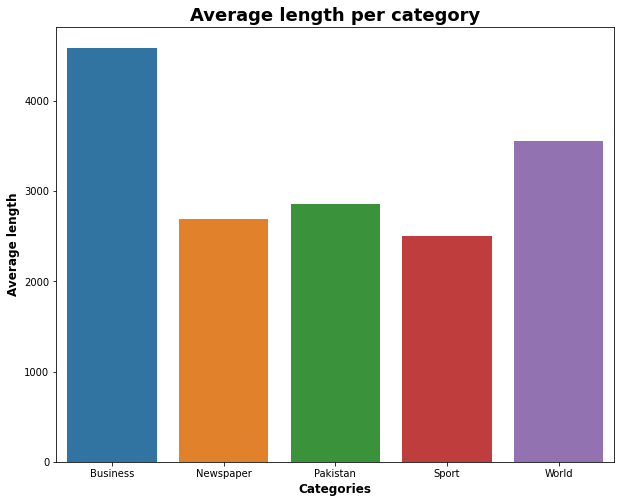

In [13]:
# Creating figure
plt.figure(figsize=(10,8))

# Creating bar plot
sns.barplot(x=text_per_cat.index,y=text_per_cat['avg_length'])

# Setting title and labels
plt.title('Average length per category',fontsize=18,fontweight='bold');
plt.ylabel('Average length',fontsize=12,fontweight='bold')
plt.xlabel('Categories',fontsize=12,fontweight='bold')
plt.show();

The above plot show us average length of text per category.

### What are the most occuring words per category?

###### Removing stop words

To find most frequent words we need to remove stop words, because counting stop words as most frequent words doesnt make any sense.

In [14]:
# Importing stop words while adding two extra words to the stop words
all_stopwords_gensim = STOPWORDS.union(set(['said','told']))

# Define a helper function to remove stop stop words from the given dataset
def remove_stopwords(text):
    
    '''Imput a text and return the same text without stop words'''
    
    filtered_text =  ' '.join([word for word in word_tokenize(text) if word not in all_stopwords_gensim])
    return filtered_text

text_per_cat['text_body'] = text_per_cat['text_body'].apply(remove_stopwords)

In [15]:
# Importing counter function
from collections import Counter

# Deifining a helper function
def frequent_words(text,number_words):
    '''Input a text and number of words , and return a list of tupples , 
    the first element of the tupple is word and 2nd element is its count that how much it has appeared in the given text.
    number of words argument is how much words you want
    '''
    # Tokanizing the text
    text = nltk.word_tokenize(text)
    
    # Passing the text into counter
    counter = Counter(text)
    # most_common() produces k frequently encountere
    # input values and their respective counts.
    most_occur = counter.most_common(number_words)
    
    return most_occur


In [16]:
text_per_cat['text_body'].apply(lambda x : frequent_words(x,number_words=10))

category
Business     [(pakistan, 32), (minister, 19), (government, ...
Newspaper    [(pakistan, 459), (government, 311), (year, 28...
Pakistan     [(government, 835), (pakistan, 507), (police, ...
Sport        [(pakistan, 56), (cricket, 50), (series, 33), ...
World        [(government, 114), (taliban, 93), (people, 79...
Name: text_body, dtype: object

##### Visualizing top words per category

In [17]:
# Creating a helper function to create a nice data_frame for each category top words

def creat_frame(Category,Range):
    '''Return a dataframe of most frequent words, when we pass category name and number of words we want
    category : category name
    number : number of frequent words
    '''
    top_words = text_per_cat['text_body'].apply(lambda x : frequent_words(x,Range))
    words ,counts = [],[]
    for word,count in top_words[Category]:
        words.append(word)
        counts.append(count)
    data_frame =  pd.DataFrame(counts,words, columns = ['counts']).reset_index().rename(columns ={'index':'words'})
    return data_frame

In [18]:
number_of_words = range(10,31)
interact(
    creat_frame,
    Category=Dropdown(options=list(text_per_cat.index)),
    Range = Dropdown(options=number_of_words)
);

interactive(children=(Dropdown(description='Category', options=('Business', 'Newspaper', 'Pakistan', 'Sport', …

In [19]:
# Define a helper function which will create barplot of frequent words per category when we pass a category name.

def creat_plot(Category,Range):
    '''Input Category and Range and return a barplot of most frequent words in the given category of give Range'''
    
    # Creating data frame
    data = creat_frame(Category,Range)
    
    # Creating figure
    plt.figure(figsize=(12,6)) 
    
    # setting theam_style
    sns.set_theme(style="whitegrid")
    
    # creating bar plot in the figure
    sns.barplot(data=data,y='words',x='counts')
    
    # Setting title and labels
    plt.title(f'Top {Range} most occuring words in {Category} category',fontsize=18,fontweight='bold');
    plt.ylabel('Words',fontsize=12,fontweight='bold')
    plt.xlabel('Frequency',fontsize=12,fontweight='bold')
    plt.show();

In [20]:

interact(
    creat_plot,
    Category=Dropdown(options=list(text_per_cat.index)),
    Range=Dropdown(options=number_of_words)
);

interactive(children=(Dropdown(description='Category', options=('Business', 'Newspaper', 'Pakistan', 'Sport', …

### Number of unique words per category

###### Removing digits 

Digits should also not be counted as unique words, we need to romve all the digits

In [21]:
# Removing Digits
import re

text_per_cat['text_body'] = text_per_cat['text_body'].apply(lambda x : re.sub(r'[0-9]+', '', x))

In [22]:
# Defining a helper function to find the number of unique words per category\
def unique_words(category):
    
    # finding unique words
    unique_words = len(set(word_tokenize(text_per_cat['text_body'][category])))
    
    # Printing the number
    print(f"Number of unique words in \033[1m'{category}' category is \033[1m{unique_words}\033[1m")

In [23]:
# Creating a dropdown interface to show number of unique words per category
interact(
    unique_words,
    category=Dropdown(options=list(text_per_cat.index))
);

interactive(children=(Dropdown(description='category', options=('Business', 'Newspaper', 'Pakistan', 'Sport', …

### What are the top ngrams of text_body per category?

Lets find out bigrams and trigrams per category and show them on chart.

In [ ]:
data['text_body'].apply(remove_stopwords)

In [28]:
get_top_ngram(data['text_body'].apply(remove_stopwords),2)

[('federal government', 107),
 ('pm imrankhankhan', 94),
 ('high court', 91),
 ('provincial government', 81),
 ('sindh government', 66),
 ('supreme court', 63),
 ('local government', 62),
 ('human rights', 60),
 ('chief justice', 56),
 ('national assembly', 43)]

In [26]:
# Defining a helper function
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# Defining a helper function which will find bigrams per category when we pass category name


def plot_ngrams(Category,Range):
    new_data = data[data['category']==Category]
    
    frequent_bigrams = get_top_ngram(new_data['text_body'].apply(remove_stopwords),Range)
    
    bigrams ,counts = [],[]
    for bigram,count in frequent_bigrams:
        bigrams.append(bigram)
        counts.append(count)

    # Creating figure
    plt.figure(figsize=(10,6))
   
    # Creating barplot
    sns.barplot(x=counts,y = bigrams)

    # Setting title and labels
    plt.title(f"N-grams of {Category} category",fontsize=18,fontweight='bold')
    plt.ylabel('N-grams', fontsize=12,fontweight='bold')
    plt.xlabel('Frequency',fontsize=12,fontweight='bold')
    plt.show();
    

In [25]:
interact(
    plot_ngrams,
    Category=Dropdown(options=list(text_per_cat.index)),
    Range= Dropdown(options=[2,3,4])
);

interactive(children=(Dropdown(description='Category', options=('Business', 'Newspaper', 'Pakistan', 'Sport', …

The above bar_plot shows bigrams per category

### Sentiment analysis per category

lets explore which each category that what kind of words are used , Negitive , Positive or neutral.

In [26]:
# Importing TextBlob
from textblob import TextBlob

# Defining a helper function 
def polarity(text):
    return TextBlob(text).sentiment.polarity

# Defining a helper function to show histogram of words when we pass category name

def sentiment(Category):
    # Creating a new data frame 
    new_data = data[data['category']==Category]
    
    # Creating figure
    plt.figure(figsize=(10,6))

    # Creating histogram
    new_data['polarity_score'] = new_data['text_body'].apply(lambda x : polarity(x))
    sns.histplot(new_data['polarity_score'])

    # Setting title and labels
    plt.title(f"Polarity score of {Category} category",fontsize=18,fontweight='bold')
    plt.ylabel('Counts', fontsize=12,fontweight='bold')
    plt.xlabel('Polarity score',fontsize=12,fontweight='bold')
    plt.show();

In [27]:
# Creating a dropdown interface to show number of unique words per category
interact(
    sentiment,
    Category=Dropdown(options=['Newspaper', 'Pakistan', 'Sport', 'World'])
);

interactive(children=(Dropdown(description='Category', options=('Newspaper', 'Pakistan', 'Sport', 'World'), va…

The above graph shows the polarity score lets classify it into negetive , positve and neutral see the results

In [28]:
# Defining a helper function, doing some small modification in the above defined sentiment function 

 # defininf classifer for the ease of work
def classifier (x):
    if x<0:
        return 'Negitive'
    elif x==0:
        return 'Neutral'
    else:
        return 'Positive'

# Defining a helper function to show histogram of words when we pass category name
def sentiment_classifier(Category):
    # Creating a new data frame 
    new_data = data[data['category']==Category]
    
    new_data['polarity_score'] = new_data['text_body'].apply(lambda x : polarity(x))
    
    new_data['polarity'] = new_data['polarity_score'].apply(lambda x : classifier (x))
    
    # Creating figure
    plt.figure(figsize=(10,6))

    # Creating histogram
    sns.countplot(new_data['polarity'])

    # Setting title and labels
    plt.title(f"Polarity of {Category} category",fontsize=18,fontweight='bold')
    plt.ylabel('Counts', fontsize=12,fontweight='bold')
    plt.xlabel('Polarity',fontsize=12,fontweight='bold')
    plt.show();

In [29]:
interact(
    sentiment_classifier,
    Category=Dropdown(options=list(text_per_cat.index))
);

interactive(children=(Dropdown(description='Category', options=('Business', 'Newspaper', 'Pakistan', 'Sport', …

The above plot shows that mostly news has posive words ,, they rarely use neutral words

# Title

### How much char are there in title averagly?

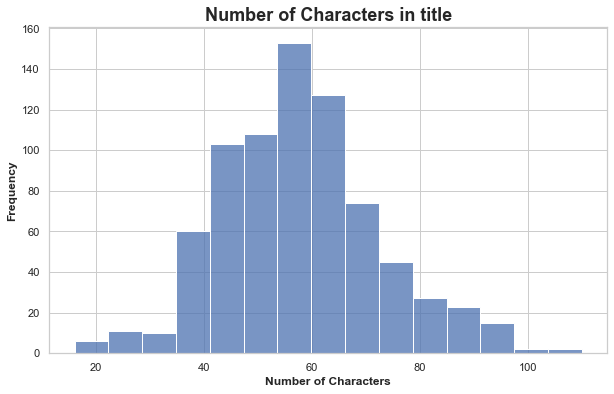

In [30]:
# Creating figure
plt.figure(figsize=(10,6))

# Creating histogram
sns.histplot(data['title'].str.len(), bins=15)

# Setting title and labels
plt.title("Number of Characters in title",fontsize=18,fontweight='bold')
plt.ylabel('Frequency', fontsize=12,fontweight='bold')
plt.xlabel('Number of Characters',fontsize=12,fontweight='bold');

The above plot shows that title ranges from 20 - 100 characters and generally, it is between 40 - 80 characters.

### How long words are used in news title averagly?

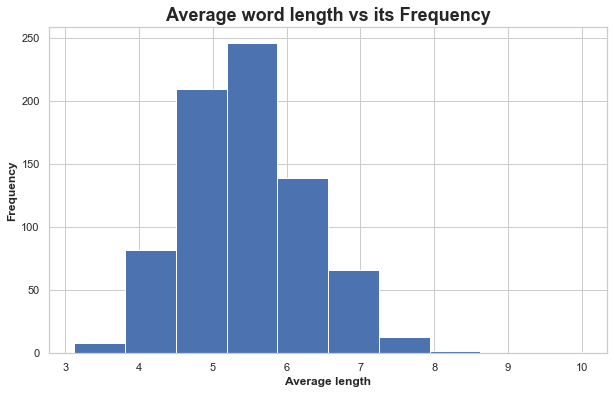

In [31]:
# Creating figure
plt.figure(figsize=(10,6))

# Creating histogram
data['title'].apply(lambda x : [len(i) for i in word_tokenize(x)]).map(lambda x: np.mean(x)).hist()

# Setting tittle and labels
plt.title("Average word length vs its Frequency",fontsize=18,fontweight='bold')
plt.ylabel('Frequency', fontsize=12,fontweight='bold')
plt.xlabel('Average length',fontsize=12,fontweight='bold');

This show that long words are not used comonly in news title, generally most its range is 4-7

### What are most frequent words used in the news title?

In [32]:
# Creating a corpus of words (removing stopwords and punctuations) , The corpus contain all the tokens of title
corpus = data['title'].apply(remove_stopwords).sum().split()

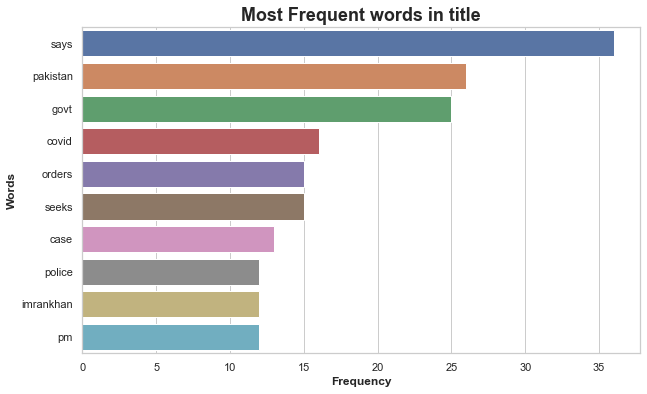

In [33]:
# couting words
counter=Counter(corpus)
# Grabing most common words
most=counter.most_common(10)

# Seperating words and its counts
words, counts= [], []
for word,count in most:
        words.append(word)
        counts.append(count)

# Creating figure
plt.figure(figsize=(10,6))

# Creating barplot
sns.barplot(x=counts,y=words)


# Setting tittle and labels
plt.title("Most Frequent words in title",fontsize=18,fontweight='bold')
plt.ylabel('Words', fontsize=12,fontweight='bold')
plt.xlabel('Frequency',fontsize=12,fontweight='bold');

### Frequent bigrams in news title

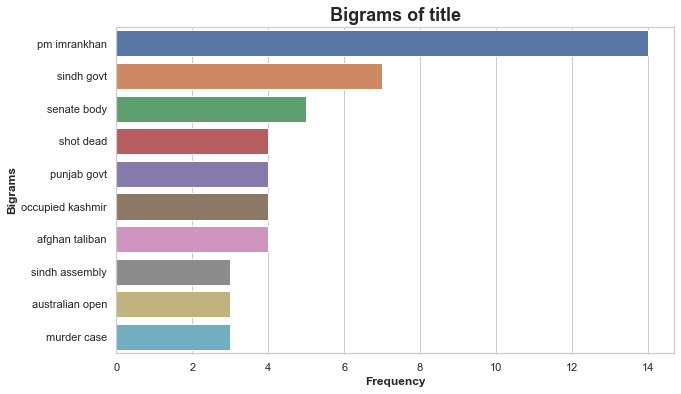

In [34]:
bigrams_of_title = get_top_ngram(data['title'].apply(remove_stopwords),2)

bigrams ,counts = [],[]
for bigram,count in bigrams_of_title:
    bigrams.append(bigram)
    counts.append(count)

# Creating figure
plt.figure(figsize=(10,6))
   
# Creating barplot
sns.barplot(x=counts,y = bigrams)

# Setting title and labels
plt.title("Bigrams of title",fontsize=18,fontweight='bold')
plt.ylabel('Bigrams', fontsize=12,fontweight='bold')
plt.xlabel('Frequency',fontsize=12,fontweight='bold');

This bar plot show PM Imran dominate the news title followed by word cup and sindh govt

### What kind of words are commonly used in news headlines Negitive, Positive or Nutural?

Lets do some sentiment analysis to find out what kind of words are commonly used 

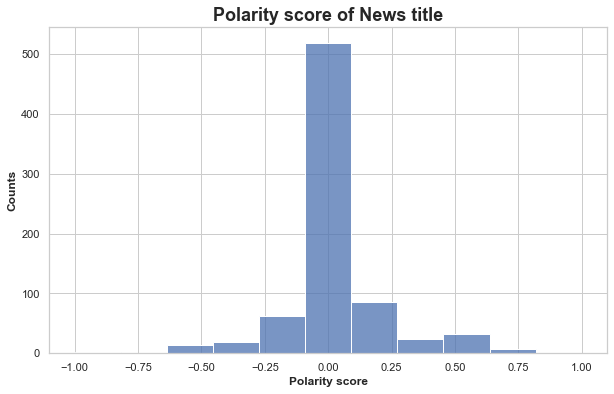

In [35]:
# Creating figure
plt.figure(figsize=(10,6))

# Creating histogram
sns.histplot(data['title'].apply(lambda x : polarity(x)))

# Setting title and labels
plt.title("Polarity score of News title",fontsize=18,fontweight='bold')
plt.ylabel('Counts', fontsize=12,fontweight='bold')
plt.xlabel('Polarity score',fontsize=12,fontweight='bold');

This plot shows that mostly news title are neutral